In [92]:
%matplotlib inline

import os
import datetime
import time
import json

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import ExtraTreesRegressor

In [2]:
## daily prices

def preprbd(x_db):
    x_db.columns = [x.lower() for x in x_db.columns.values]
    x_db.drop(['date_text','month','month day','day','year'],axis=1,inplace=True)
    x_db.drop(['open','high','low','market cap'],axis=1,inplace=True)


bit_price_d = pd.read_excel("bitcoin_data/btc_close_daily.xlsx")
preprbd(bit_price_d)
bit_price_d.rename(columns={'close':'btc_close'},inplace=True)

eth_price_d = pd.read_excel("bitcoin_data/eth_close_daily.xlsx")
preprbd(eth_price_d)
eth_price_d.rename(columns={'close':'eth_close'},inplace=True)

eth_price_d.head()

,date,eth_close,volume
0,2018-04-01,379.61,1256930000
1,2018-03-31,396.46,1323920000
2,2018-03-30,394.65,1878130000
3,2018-03-29,385.97,1970230000
4,2018-03-28,446.28,1514180000


In [3]:
## minute prices
##

bit_price = pd.read_csv('bitcoin_data/bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv')
bit_price.columns = [x.lower() for x in bit_price.columns.values]
bit_price['date_time'] = bit_price['timestamp'].map(lambda x: datetime.datetime.fromtimestamp(x)) ## MSC timezone
bit_price.head()

,timestamp,open,high,low,close,volume_(btc),volume_(currency),weighted_price,date_time
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:52:00
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:53:00
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:54:00
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:55:00
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:56:00


#### Graphs

Bitcoin price evalution 

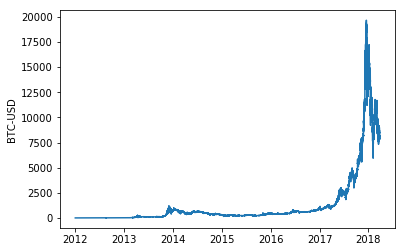

In [5]:
fig, ax = plt.subplots()
ax.plot(bit_price['date_time'],bit_price['open'])
ax.set_ylabel('BTC-USD')

plt.show()

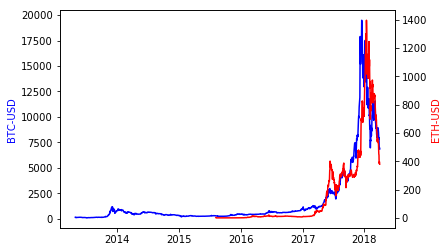

In [6]:
fig, ax1 = plt.subplots()

ax1.plot(bit_price_d['date'],bit_price_d['btc_close'],'b')
ax1.set_ylabel('BTC-USD',color='b')


ax2 = ax1.twinx()
ax2.plot(eth_price_d['date'],eth_price_d['eth_close'],'r')
ax2.set_ylabel('ETH-USD', color='r')
plt.show()

#### Reading news

In [308]:
%%time

def clean_text(text):
    text = re.sub("<.*?>.*?</.*?>","",text)
    text = re.sub("&amp;","&",text)
    text = re.sub("\n"," ",text)

    return text
    

## Loading text
DIR_FILE = "news_coindesk"
cd_news = []
for i_file in os.listdir(DIR_FILE):
    
    # read file
    tt = open (DIR_FILE + "/"+i_file)
    
    # process headline
    news_headline = tt.readline()
    news_headline = re.sub("\n","",news_headline)
    
    # now time for time
    news_time = tt.readline()
    news_time = datetime.datetime.strptime(news_time[0:10],"%Y-%m-%d")
    
    # news text and brief
    news_text = "".join(tt.readlines())
    try:
        news_brief = re.search("<brief>(.*?)</brief>",news_text).group(1)
    except:
        news_brief = ""
    news_text = clean_text(news_text)
    cd_news.append([news_time,news_headline,news_text])
    
    
print ("text loaded")

cd_news = pd.DataFrame(cd_news)
cd_news.columns = ['date','headline','text']

## aggregate text and headlines on daily level
def compute_metrics(x):
    result = {'headline': " ".join(x['headline']), 'text': " ".join(x['text']),'count_news':len(x)}
    return pd.Series(result, name='metrics')

cd_news = cd_news.groupby('date').apply(compute_metrics)


cd_news.reset_index(inplace=True)
cd_news.sort_values('date',inplace=True)

## MAKE DATE SHIFT
cd_news['date'] = [x + datetime.timedelta(days=1) for x in cd_news['date']]

print ("metrics computed")

cd_news.head()

text loaded
metrics computed
Wall time: 4.89 s


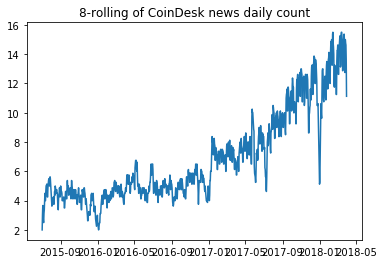

In [309]:
## Plot news count

fig, axs = plt.subplots()

aa = cd_news.rolling(8,min_periods=1)['count_news'].mean()
axs.plot(cd_news['date'],aa)
axs.title.set_text("8-rolling of CoinDesk news daily count")
plt.show()

In [330]:
##  Get daily spot price
##
all_data = bit_price_d[['date','btc_close']].copy(deep=True)
all_data.sort_values('date',ascending=True,inplace=True)
all_data.reset_index(inplace=True)
all_data.drop('index',axis=1,inplace=True)


## make returns
price = all_data['btc_close']
price_l1 = all_data['btc_close'].shift(1)
all_data['btc_return'] = (price - price_l1)/price_l1 * 100
all_data.dropna(inplace=True)


##  merge with news
all_data = all_data.merge(cd_news,how='left',on='date')
all_data.fillna('',inplace=True)


## make tfidf
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidif_vectors = tfidf.fit_transform(all_data['text'])
tfidf_col_names = tfidf.get_feature_names() ## list(tfidf.vocabulary_.keys())

tfidif_vectors


<1799x1001872 sparse matrix of type '<class 'numpy.float64'>'
	with 4219112 stored elements in Compressed Sparse Row format>

In [331]:
## split into test and train
##

date_start = '2018-01-01'

filter_train = all_data['date'] < date_start
filter_test  = all_data['date'] >= date_start


matr = tfidif_vectors

dates_train =all_data.loc[filter_train,'date']
X_train = matr[np.where(filter_train)[0],]
y_train = all_data.loc[filter_train,'btc_return']

dates_test = all_data.loc[filter_test,'date']
X_test = matr[np.where(filter_test)[0],]
y_test =  all_data.loc[filter_test,'btc_return']

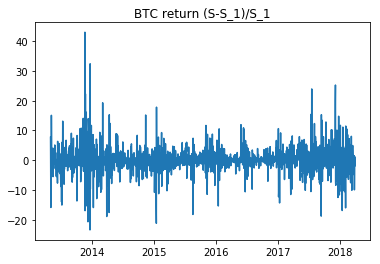

In [332]:
fig, ax = plt.subplots()
ax.plot(all_data['date'],all_data['btc_return'])
ax.set_title("BTC return (S-S_1)/S_1")

#### Ridge Model

In [333]:
def model_predict (mm,titles=["",""]):
    assert len(titles)==2
    
    y_pred = mm.predict(X_test)

    print (mean_squared_error(y_pred,y_test))
    print (r2_score(y_pred,y_test))


    y_pred = mm.predict(X_train)

    print (mean_squared_error(y_pred,y_train))
    print (r2_score(y_pred,y_train))

    ## Plot train data
    fig, (axs) = plt.subplots()
    axs.plot(dates_train,y_train,'b')
    axs.plot(dates_train,y_pred,'r')
    axs.set_title(titles[0])
    ## Plot test data
    y_pred = mm.predict(X_test)
    
    fig2, (axs2) = plt.subplots()
    axs2.plot(dates_test,y_test,'b')
    axs2.plot(dates_test,y_pred,'r')
    axs2.set_title(titles[1])

    fig2.autofmt_xdate()
    plt.show()

37.6504392034
-59.0804475289
11.8918961747
-0.548885971177


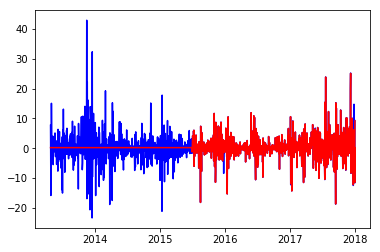

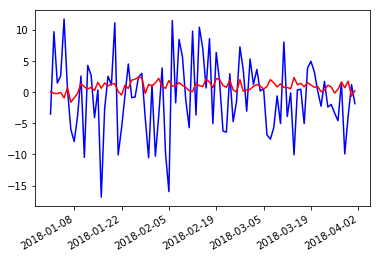

In [334]:
mm = Ridge(alpha=0.0, fit_intercept=True, normalize=False)
mm.fit(X_train,y_train)

model_predict(mm)

In [335]:
ind = np.argsort(np.abs(mm.coef_))
ind = ind[::-1]

for i_ind in ind[0:20]:
    feat = tfidf_col_names[i_ind]
    print (feat, mm.coef_[i_ind])


briggs 9.28454071814
popper -8.64118649713
they 7.055661649
xie 6.70267543516
xrps 6.52100268946
dubai -6.45686767543
at -6.20116131353
everipedia 6.12817785489
auction -5.75558593394
harris 5.73359153572
farmer -5.65487090401
could -5.46948757645
government -5.43933481447
brave -5.4253592398
coindash 5.40421502502
march -5.3798184361
xt -5.2978926668
as 5.27892079599
within -5.14381912232
mdls 5.08598973534


37.6504392034
-59.0804475289


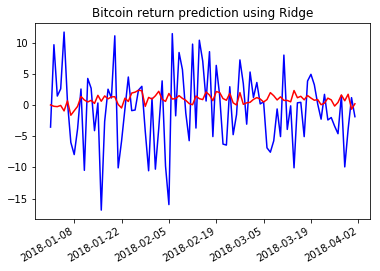

In [336]:
y_pred = mm.predict(X_test)

print (mean_squared_error(y_pred,y_test))
print (r2_score(y_pred,y_test))

fig,axs = plt.subplots()
axs.plot(dates_test,y_test,'b')
axs.plot(dates_test,y_pred,'r')
axs.set_title('Bitcoin return prediction using Ridge')
fig.autofmt_xdate()

plt.show()

#### Extra Trees

In [ ]:
%% time
etr  = ExtraTreesRegressor(n_estimators=50, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1)
etr.fit(X_train,y_train)

In [ ]:
model_predict(etr,titles=["","Bitcoin prediction using ExtraTrees"])

In [ ]:
imp = etr.feature_importances_
ind = np.argsort(imp)
ind = ind[::-1]

for i_ind in ind[0:20]:
    feat = tfidf_col_names[i_ind]
    print (feat, imp[i_ind])


In [326]:
for i_hh in all_data['headline']:
    aa = re.search('more to',i_hh,re.IGNORECASE)
    if aa is not None:
        print (i_hh,"\n")

$240: Monero Prices Hit Record High and Could Climb Further  A Missouri Lawmaker Wants to Ban Blockchain Gun Tracking  'All-You-Can-Fly' Airline Begins Accepting Bitcoin and Ether  Detroit Bitcoin Trader Gets Jail Time for Unlicensed Money Business  ICO Delayed by Ethereum's CryptoKitties Congestion  'More Bang for Less Byte': ICOs Confront Growing Pains  Overbought? Bitcoin Eyes $12k, But Correction Possible  R3's Corda Platform Launches on Amazon Web Services  Teams and Products Aren't the Only Way to Weigh Tokens, Says Ehrsam  Token Summit Surprise: OpenBazaar to Launch New Coin  Tokyo Financial Exchange Planning Bitcoin Futures Launch  Bitcoin Futures: Make Way for a New Kind of Whale  G-Eazy, Mariah and More to Sell Albums for Monero  One Marshmallow Now, or Two Bitcoins in 15 Minutes?  PayPal's Max Levchin: Blockchain 'Brilliant' But Undecided on Bitcoin  PetroBLOQ Becomes Latest Member of Enterprise Ethereum Alliance  UBS Seeks IP Protection for Smart Contract Blockchain Validat

In [328]:
i_col = np.where([x == 'more to' for x in tfidf_col_names])[0]
i_col = i_col[0]

print (tfidf_col_names[i_col])
aa = pd.DataFrame(tfidif_vectors[:,i_col].todense())
aa.columns = ["word"]
aa = aa.query("word>0")
print (aa)

more to
          word
1682  0.065683
1692  0.065637


In [329]:
all_data.loc[1682,'headline']

"$240: Monero Prices Hit Record High and Could Climb Further  A Missouri Lawmaker Wants to Ban Blockchain Gun Tracking  'All-You-Can-Fly' Airline Begins Accepting Bitcoin and Ether  Detroit Bitcoin Trader Gets Jail Time for Unlicensed Money Business  ICO Delayed by Ethereum's CryptoKitties Congestion  'More Bang for Less Byte': ICOs Confront Growing Pains  Overbought? Bitcoin Eyes $12k, But Correction Possible  R3's Corda Platform Launches on Amazon Web Services  Teams and Products Aren't the Only Way to Weigh Tokens, Says Ehrsam  Token Summit Surprise: OpenBazaar to Launch New Coin  Tokyo Financial Exchange Planning Bitcoin Futures Launch  Bitcoin Futures: Make Way for a New Kind of Whale  G-Eazy, Mariah and More to Sell Albums for Monero  One Marshmallow Now, or Two Bitcoins in 15 Minutes?  PayPal's Max Levchin: Blockchain 'Brilliant' But Undecided on Bitcoin  PetroBLOQ Becomes Latest Member of Enterprise Ethereum Alliance  UBS Seeks IP Protection for Smart Contract Blockchain Valida